In [64]:
import pandas as pd 
import numpy as np 
from numpy.fft import fft
import matplotlib.pyplot as plt
import fastparquet
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew
from scipy.stats import linregress
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import find_peaks
from scipy.stats import entropy
import joblib

from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score


from xgboost import plot_importance, XGBClassifier
from tqdm import tqdm
from sklearn.svm import SVC


Загрузим тренировочный датасет

In [35]:
data = pd.read_parquet('data/train.parquet')
data

,id,dates,values,label
0,19114,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01T00:00:00.000000000, 2016-06-01T00:...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01T00:00:00.000000000, 2017-04-01T00:...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01T00:00:00.000000000, 2018-11-01T00:...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01T00:00:00.000000000, 2016-08-01T00:...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01T00:00:00.000000000, 2016-04-01T00:...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01T00:00:00.000000000, 2016-03-01T00:...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


**Посмотрим на наличие пропущенных значений**

В тестовых данных тоже есть пропуски, но пропуски и в тесте и в трейне такого характера, что значение поля `value` в случае пропуска - это массив из `None` вместо временного ряда. Можно было бы заполнить эти пропуски на основании временного промежутка, когда они были записаны, но, как выяснится при формировании признаков, время записи ряда не влияет на метку классса. 

In [36]:
def has_none(time_series):
    return any(item is np.inf or item is np.nan or item is None  for item in time_series)

none_id = data[data['values'].apply(lambda x: has_none(x))].index.tolist() + data[data['dates'].apply(lambda x: has_none(x))].index.tolist()


**Пропусков всего лишь 88, поэтому просто удалим эти строки**

In [37]:
len(none_id)

88

In [38]:
data.drop(none_id, inplace= True)

Посмотрим на то, сбалансированны ли классы

In [39]:
data.groupby(['label']).count()

,id,dates,values
label,,,
0.0,57785,57785,57785
1.0,22127,22127,22127


**Классы 0 и 1 распределены в соотношении примерно 60% к 40%, можно считать это за легкий дисбаланс**

В поле `dates` указаны временные метки для рядов. Если строить график рядов только по значениям, то не будет учитываться время начала и конца наблюдения. Возможно на класс будет влиять, в какой промежуток времени происходили замеры. Поэтому создадим поле `dates_int`, где временные отсечки выражены в днях после самого раннего наблюдения. 

In [40]:
min_day = np.min(data['dates'].apply(lambda x: np.min(x)))

In [41]:
max_day = np.max(data['dates'].apply(lambda x: np.max(x)))

In [42]:
(max_day - min_day).days

2922

Всего замеры охватывают диапазон в 2922 дня

In [43]:
data['dates_int'] = data['dates'].apply(lambda x: [(date - min_day).days for date in x])

**Создадим поля `start_date` и `end_date`. Посмотрим, влияет ли на метку класса фактор, когда замеры были начаты и когда были закончены**

In [44]:
data['start_date'] = data['dates_int'].apply(lambda x: x[0])
data['end_date'] = data['dates_int'].apply(lambda x: x[-1])

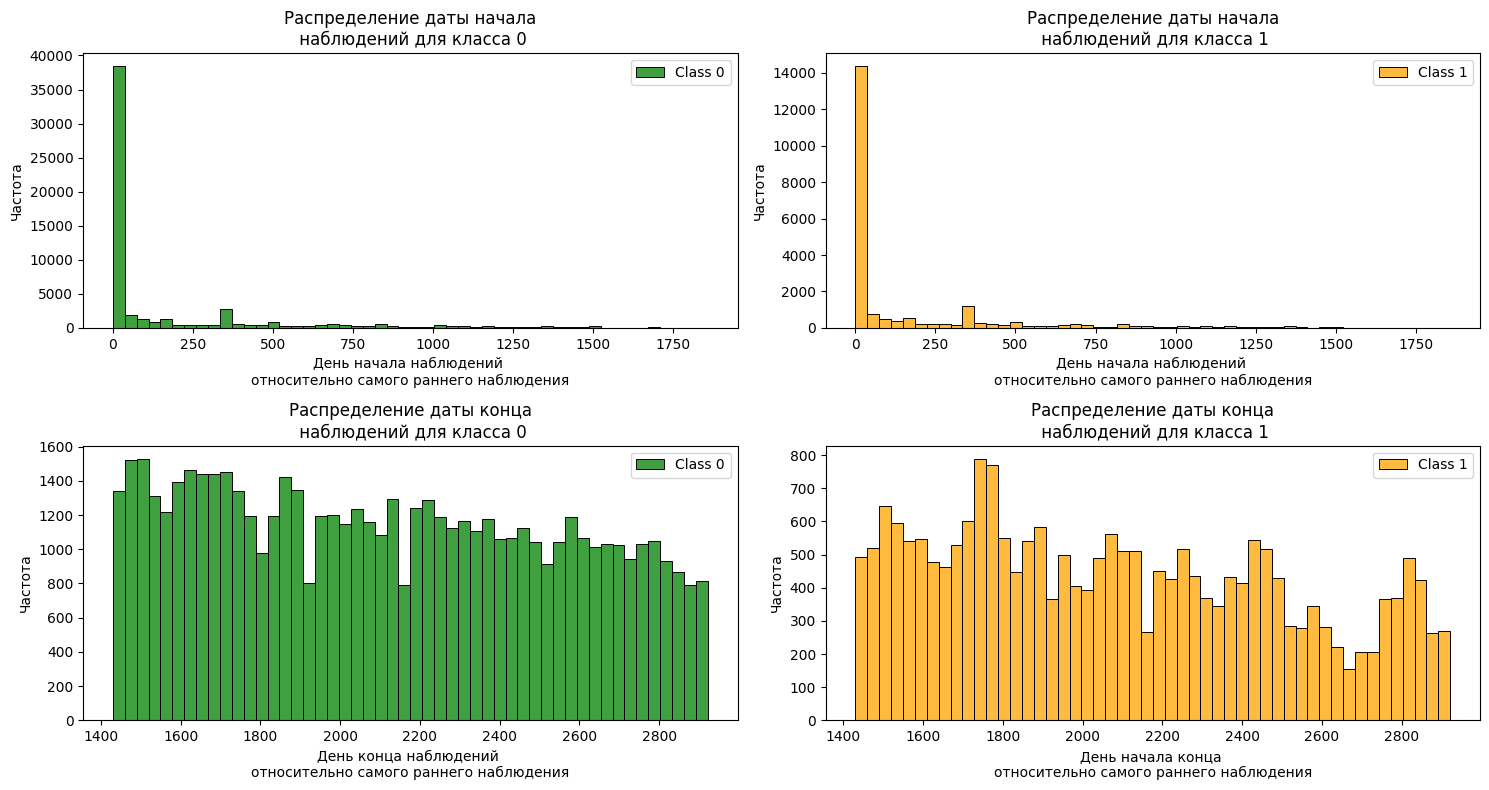

In [45]:
bins_n = 50

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(data[data['label'] == 0]['start_date'], color='green', label='Class 0', bins= bins_n)
plt.legend()
plt.title('Распределение даты начала\n наблюдений для классa 0')
plt.xlabel('День начала наблюдений \nотносительно самого раннего наблюдения')
plt.ylabel('Частота')

plt.subplot(2, 2, 2)
sns.histplot(data[data['label'] == 1]['start_date'], color='orange', label='Class 1', bins= bins_n)

plt.legend()
plt.title('Распределение даты начала\n наблюдений для класса 1')
plt.xlabel('День начала наблюдений \nотносительно самого раннего наблюдения')
plt.ylabel('Частота')

plt.subplot(2, 2, 3)
sns.histplot(data[data['label'] == 0]['end_date'], color='green', label='Class 0', bins= bins_n)
plt.legend()
plt.title('Распределение даты конца\n наблюдений для классa 0')
plt.xlabel('День конца наблюдений \nотносительно самого раннего наблюдения')
plt.ylabel('Частота')

plt.subplot(2, 2, 4)
sns.histplot(data[data['label'] == 1]['end_date'], color='orange', label='Class 1', bins= bins_n)

plt.legend()
plt.title('Распределение даты конца\n наблюдений для класса 1')
plt.xlabel('День начала конца \nотносительно самого раннего наблюдения')
plt.ylabel('Частота')


plt.tight_layout()
plt.show()

Можно сказать, что для обоих классов **дни начала и конца наблюдений распределены одинаково**, поэтому то, в какой день измерения начались и когда измерения закончились, **не влияет** на метку класса

**Посмотрим на то, как распределена длина рядов для разных классов и на длину рядов в целом как на переменную**

In [46]:
data['len'] = data['dates'].apply(len)
data[['len']].describe()

,len
count,79912.000000
mean,64.456277
std,15.396889
min,36.000000
25%,52.000000
50%,62.000000
75%,76.000000
max,97.000000


Количество отсечек в ряду колеблется от о 36 до 97, посмотрим, влияет ли длина ряда на метку класса

In [47]:
data.groupby('label').agg({'len': 'mean'})

,len
label,
0.0,64.753275
1.0,63.680662


Для каждого класса средняя длина наблюдаемых рядов практически не отличается

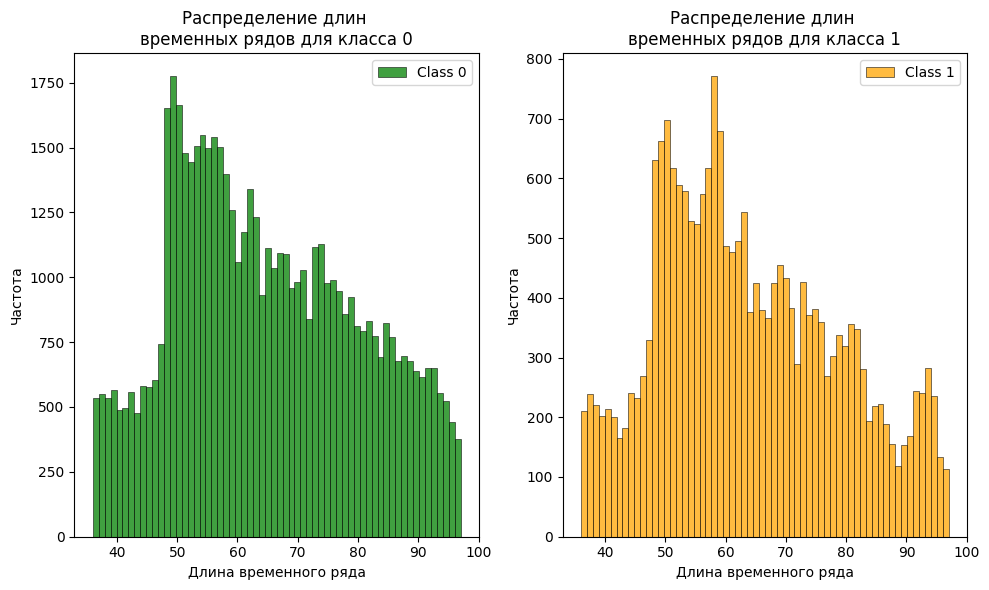

In [48]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(data[data['label'] == 0]['len'], color='green', label='Class 0', bins= 62)
plt.legend()
plt.title('Распределение длин \nвременных рядов для класса 0')
plt.xlabel('Длина временного ряда')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(data[data['label'] == 1]['len'], color='orange', label='Class 1', bins= 62)
plt.legend()
plt.title('Распределение длин \nвременных рядов для класса 1')
plt.xlabel('Длина временного ряда')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

На гистограмме можем видеть расрпделение длин наблюдаемых рядов для объектов класса 0 и 1. Визуально **классы имеют одинаковое распределение**, поэтому можно предположить, что этот **фактор не влияет на метку класса**

Давайте попробуем посмотреть на 10 случайных рядов класса 1 и 10 случайных рядов класса 0. Изобразим на графике 10 пар, в первом столбце будет класс 0, во втором класс 1. Возможно визуально получится найти различия между ними.

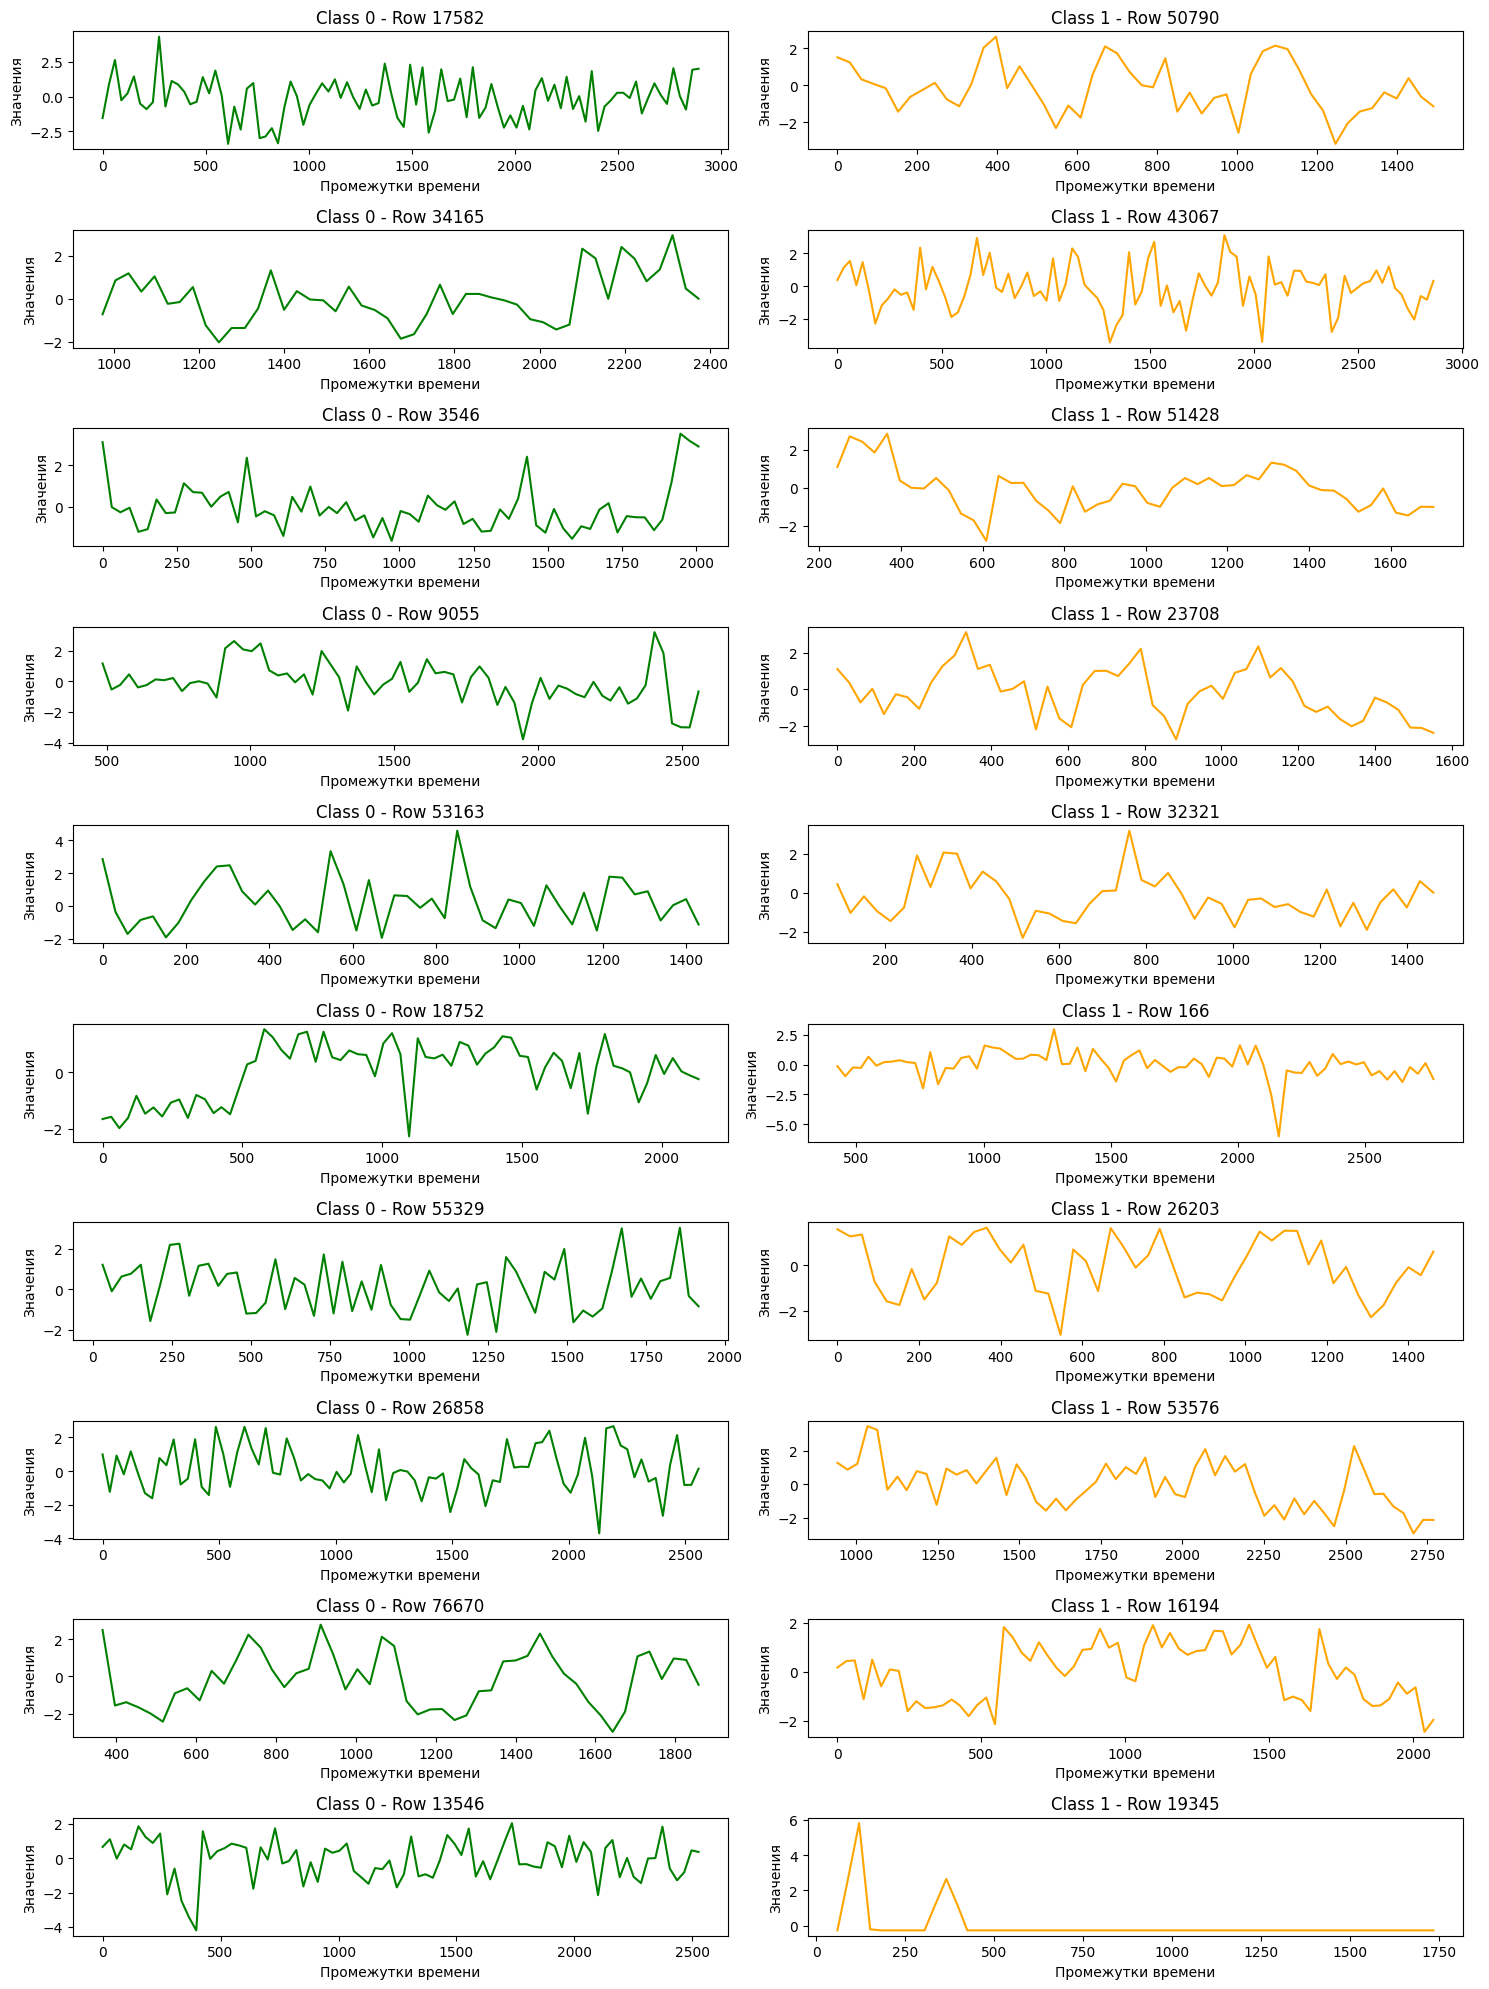

In [49]:
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

random_idx_0 = np.random.choice(class_0.index, 10, replace=False)
random_idx_1 = np.random.choice(class_1.index, 10, replace=False)

plt.figure(figsize=(15, 20))

for i, (idx_0, idx_1) in enumerate(zip(random_idx_0, random_idx_1)):
   
    plt.subplot(10, 2, 2*i+1)  
    plt.plot(data.loc[idx_0, 'dates_int'], data.loc[idx_0, 'values'], color='green')
    plt.title(f'Class 0 - Row {idx_0}')
    plt.xlabel('Промежутки времени')
    plt.ylabel('Значения')

    plt.subplot(10, 2, 2*i+2)  
    plt.plot(data.loc[idx_1, 'dates_int'], data.loc[idx_1, 'values'], color='orange')
    plt.title(f'Class 1 - Row {idx_1}')
    plt.xlabel('Промежутки времени')
    plt.ylabel('Значения')

plt.tight_layout()
plt.show()

**Конечно же, выборку из 10 рядов нельзя считать репрезентативной в нашем случае**. Но, как мне показалось, ряды из класса 1 имеют больее организованную структуру - в них четче прослеживается общая динамика на увеличение или уменьшение значений, т.е какой-то тренд, проглядываются повторяющиеся элементы, т.е что-то наподобие сезонности. Ряды класса 0 кажутся мне более хаотичными. **Но в общем-то выводы по этим графикам нельзя генерализовать на весь датасет.**

**Поизвлекаем из рядов статистические характеристики**

Для каждого ряда извлечем статистические признаки:

        - Максимум
        
        - Минимум

        - Медиана

        - Среднее значение

        - Дисперсию

        - Минимальное и максимальное значение

        - 25 и 75 процентиль

        - Коэффициент ассиметрии

        - Количество экстремумов

        - Коэффициент линейного тренда

        - Коэффициенты автокорреляции

        - Максимальная длительность фазы - длина последовательности выше среднего значения

        - Средняя абсолютная разница между соседними значениями

        - Энтропия Шеннона
        

**Далее создадим признаки по аппроксимирующим моделям:**

        
        
        - Первые 7 абсолютных значений коэффициентов Фурье

        - Средняя амплитуда сигнала через преобразование Фурье

        - Первые 7 значений коэффициентов авторегрессии

        



**Создадим датафрейм из статистических фичей**

In [50]:
stat_feachure = pd.DataFrame()

In [51]:
%%time

def linear_trend(values):
    x = np.arange(len(values)) 
    slope, intercept, r_value, p_value, std_err = linregress(x, values)
    return slope  

def phase_duration(series):
    mean_value = np.mean(series)
    above_mean = series > mean_value
    max_phase = 1
    current_phase = 1

    for i in range(1, len(above_mean)):
        if above_mean[i] == above_mean[i - 1]:
            current_phase += 1
        else:
            max_phase = max(max_phase, current_phase)
            current_phase = 1

    return max(max_phase, current_phase)


def max_trend_length(series):
    diffs = np.diff(series)
    trend_length = 1
    max_trend = 1

    for i in range(1, len(diffs)):
        if diffs[i] * diffs[i-1] > 0:  # Проверка направления тренда
            trend_length += 1
        else:
            max_trend = max(max_trend, trend_length)
            trend_length = 1
    
    max_trend = max(max_trend, trend_length)  # На случай, если тренд до конца
    return max_trend

def time_series_entropy(series):
    value_counts = np.histogram(series, bins=10, density=True)[0]
    return entropy(value_counts + 1e-10)


def make_stat_feachures(stat_feachure):

    stat_feachure['max'] = data['values'].apply(lambda x: np.max(x))
    stat_feachure['min'] = data['values'].apply(lambda x: np.min(x))
    stat_feachure['median'] = data['values'].apply(lambda x: np.median(x))
    
    stat_feachure['mean'] = data['values'].apply(lambda x: np.mean(x))
    stat_feachure['var'] = data['values'].apply(lambda x: np.var(x))
    stat_feachure['amplitude'] = data['values'].apply(lambda x: np.max(x) - np.min(x))
    stat_feachure['peaks_valleys'] = data['values'].apply(lambda x: len(find_peaks(x)[0]) + len(find_peaks(-1*np.array(x))[0]))
    
    
    stat_feachure['skew'] = data['values'].apply(lambda x: skew(x))
    stat_feachure['percentile_25'] = data['values'].apply(lambda x: np.percentile(x, 25))
    stat_feachure['percentile_75'] = data['values'].apply(lambda x: np.percentile(x, 75))
        
    stat_feachure['linear_trend'] = data['values'].apply(linear_trend)
    
    stat_feachure['mean_abs_diff'] = data['values'].apply( lambda x: np.mean(np.abs(np.diff(x))))
    stat_feachure['phase_dur'] = data['values'].apply(phase_duration)
    stat_feachure['max_trend_len'] = data['values'].apply(max_trend_length)
    stat_feachure['Shenon_entropy'] = data['values'].apply(time_series_entropy)
  
    
    

make_stat_feachures(stat_feachure)


CPU times: user 1min, sys: 127 ms, total: 1min 1s
Wall time: 1min


**Сбросим индексы, чтобы избежать ошибок при обьединении признаковых таблиц**

In [52]:
stat_feachure.reset_index(drop= True, inplace= True)

**Добавим в признаковое пространство первые 7 коэффициентов Фурье (абсолютных значений)**

In [53]:
def fourier_coefficients(values, n=7):
    fft_vals = fft(values)
    return np.abs(fft_vals[:n])

In [54]:
f_coefs = data['values'].apply(fourier_coefficients)
fourier_df = pd.DataFrame(f_coefs.tolist(), columns=[f'fourier_coeff_{i+1}' for i in range(7)])

fourier_df

,fourier_coeff_1,fourier_coeff_2,fourier_coeff_3,fourier_coeff_4,fourier_coeff_5,fourier_coeff_6,fourier_coeff_7
0,1.470000,11.308932,4.484992,0.948133,5.310429,16.751549,4.967958
1,13.984957,19.890792,9.176199,3.948407,12.334670,12.968146,12.569246
2,2.210000,20.514392,5.375923,7.108244,15.642516,5.336164,5.630582
3,6.240000,30.757721,4.131275,2.361102,12.573364,4.289569,3.985212
4,15.150000,5.319692,2.669083,5.345714,1.152873,21.570369,5.997493
...,...,...,...,...,...,...,...
79907,9.010000,9.352903,5.757932,5.662446,15.763555,15.441745,9.640407
79908,5.965430,2.288812,8.012206,13.523148,23.811466,20.776852,5.140345
79909,10.270000,25.380554,12.005960,1.445251,10.072403,7.063426,4.385645
79910,4.750000,12.969496,2.579450,24.479073,14.640147,31.562023,12.750592


**Добавим в признаковое пространство первые 10 коэффициентов авторегрессии**

In [55]:
def ar_coefficients(values, lags=7):
    model = AutoReg(values, lags=lags).fit()
    return model.params[1:]  

In [56]:
%%time
ar_coefs = data['values'].apply(ar_coefficients)
ar_df = pd.DataFrame(ar_coefs.tolist(), columns=[f'ar_coef_{i+1}' for i in range(7)])

ar_df

CPU times: user 1min 48s, sys: 63 ms, total: 1min 48s
Wall time: 1min 48s


,ar_coef_1,ar_coef_2,ar_coef_3,ar_coef_4,ar_coef_5,ar_coef_6,ar_coef_7
0,-0.123190,-0.071630,-0.077993,0.117576,-0.235664,-0.005870,0.130564
1,0.199947,-0.015431,0.014978,0.025688,0.005312,0.159423,-0.069798
2,0.477010,0.207654,-0.094763,0.014317,-0.014849,0.048357,-0.062632
3,0.708228,-0.259462,0.556924,-0.246279,0.146720,-0.021012,-0.008686
4,-0.023451,-0.249909,-0.152563,-0.162069,-0.242916,-0.114563,-0.137171
...,...,...,...,...,...,...,...
79907,0.072564,-0.060347,-0.177438,0.053154,-0.373962,-0.114017,-0.157037
79908,0.112538,0.107889,-0.001747,-0.135243,-0.269822,-0.111842,-0.241484
79909,0.050406,0.286148,-0.004183,-0.052849,0.209549,0.094120,0.077297
79910,0.330473,0.142769,-0.194577,0.010949,0.017243,-0.178150,-0.111719


**Исследуем статистические признаки**

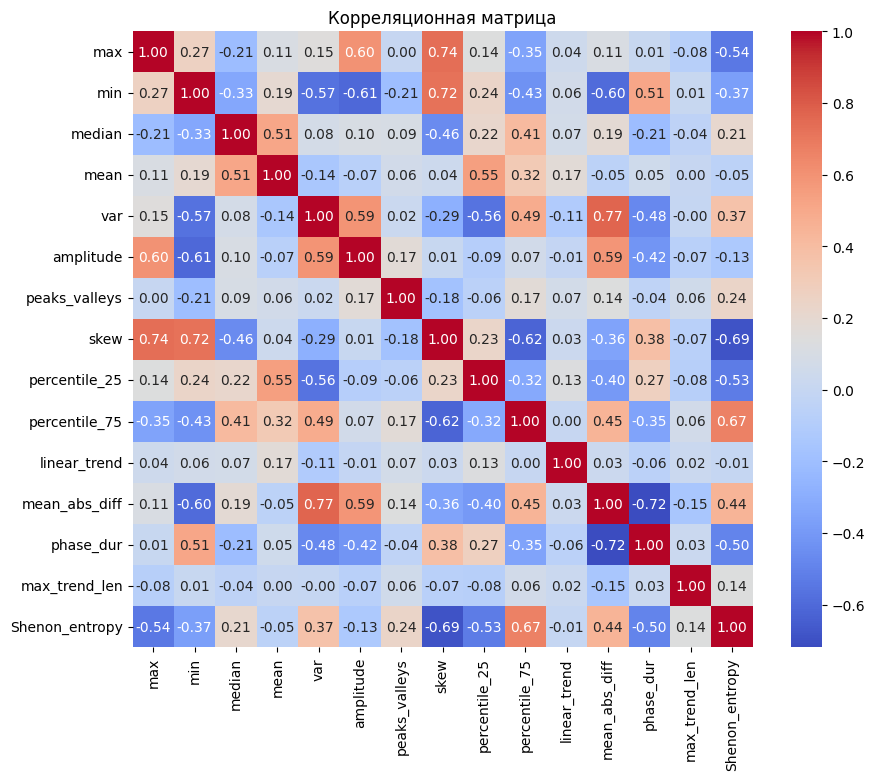

In [57]:
plt.figure(figsize=(10, 8))  
sns.heatmap(stat_feachure.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Корреляционная матрица')
plt.show()

Среди признаков, которые я генерировал, были признаки `valleys` - количество локальных минимумов и `mean_abs_deviation` - среднее абсолютное отклонение от матожидания. Признак `valleys` коррелировал с признаком `peaks` - количество локальных максимумов. Поэтому я обьединил их в один признак `peaks and values` - количество локальных экстремумов. Признак `mean_abs_deviation` сильно коррелировал с `var` - дисперсией, что в целом было очевидно. Поэтому я оставил только `var`.
В датасете `stat_feachure` остались признаки, попарные корреляции которых не привышают 0.8. 

Давайте теперь **соберем в одну матрицу все три матрицы признаков**: статистическую, с коэффициентами Фурье и с коэффициентами авторегрессии

In [58]:
feachures = pd.concat([stat_feachure, fourier_df, ar_df], axis = 1)
feachures

,max,min,median,mean,var,amplitude,peaks_valleys,skew,percentile_25,percentile_75,...,fourier_coeff_5,fourier_coeff_6,fourier_coeff_7,ar_coef_1,ar_coef_2,ar_coef_3,ar_coef_4,ar_coef_5,ar_coef_6,ar_coef_7
0,3.49,-4.840000,-0.110000,0.023710,1.788298,8.330000,37,-0.304166,-0.682500,0.7700,...,5.310429,16.751549,4.967958,-0.123190,-0.071630,-0.077993,0.117576,-0.235664,-0.005870,0.130564
1,2.92,-3.534409,-0.274409,-0.310777,2.422185,6.454409,29,-0.011952,-1.040000,0.7100,...,12.334670,12.968146,12.569246,0.199947,-0.015431,0.014978,0.025688,0.005312,0.159423,-0.069798
2,2.61,-1.950000,-0.145000,-0.046042,1.134274,4.560000,29,0.377148,-0.877500,0.6150,...,15.642516,5.336164,5.630582,0.477010,0.207654,-0.094763,0.014317,-0.014849,0.048357,-0.062632
3,2.49,-2.220000,-0.345000,-0.130000,1.341429,4.710000,22,0.112395,-0.950000,0.8250,...,12.573364,4.289569,3.985212,0.708228,-0.259462,0.556924,-0.246279,0.146720,-0.021012,-0.008686
4,2.87,-2.500000,-0.475000,-0.270536,1.614244,5.370000,35,0.398655,-1.250000,0.6775,...,1.152873,21.570369,5.997493,-0.023451,-0.249909,-0.152563,-0.162069,-0.242916,-0.114563,-0.137171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79907,2.56,-3.640000,0.160000,0.163818,1.700325,6.200000,33,-0.717290,-0.360000,1.0150,...,15.763555,15.441745,9.640407,0.072564,-0.060347,-0.177438,0.053154,-0.373962,-0.114017,-0.157037
79908,2.16,-2.590000,-0.180000,-0.112555,1.479659,4.750000,32,0.111317,-1.120319,1.1200,...,23.811466,20.776852,5.140345,0.112538,0.107889,-0.001747,-0.135243,-0.269822,-0.111842,-0.241484
79909,2.27,-2.890000,-0.140000,-0.201373,1.398428,5.160000,34,-0.055628,-0.905000,0.4950,...,10.072403,7.063426,4.385645,0.050406,0.286148,-0.004183,-0.052849,0.209549,0.094120,0.077297
79910,3.11,-2.850000,0.240000,-0.075397,2.223838,5.960000,39,-0.142759,-1.465000,0.9850,...,14.640147,31.562023,12.750592,0.330473,0.142769,-0.194577,0.010949,0.017243,-0.178150,-0.111719


In [59]:
print(feachures.isnull().sum())

max                0
min                0
median             0
mean               0
var                0
amplitude          0
peaks_valleys      0
skew               0
percentile_25      0
percentile_75      0
linear_trend       0
mean_abs_diff      0
phase_dur          0
max_trend_len      0
Shenon_entropy     0
fourier_coeff_1    0
fourier_coeff_2    0
fourier_coeff_3    0
fourier_coeff_4    0
fourier_coeff_5    0
fourier_coeff_6    0
fourier_coeff_7    0
ar_coef_1          0
ar_coef_2          0
ar_coef_3          0
ar_coef_4          0
ar_coef_5          0
ar_coef_6          0
ar_coef_7          0
dtype: int64


Таблицы с признаками объединились правильно, среди значений нет NaN-ов.

**Выбор признаков, масштабирование и обучение модели**


Теперь у нас есть датасет `feachures`, в котором содержатся признаковое описание наблюдений, а так же поле `target` - это метки классов

In [60]:
target = data['label'].reset_index(drop= True)
target

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
79907    0.0
79908    1.0
79909    0.0
79910    0.0
79911    1.0
Name: label, Length: 79912, dtype: float64

**Давайте стандартизируем признаки - приведем значения полей к распределению с нулевым средним и единичной дисперсией**

Получим датафрейм `feachures_scaled` стандартизированных признаков

In [61]:
scaler = StandardScaler()

feachures_scaled = pd.DataFrame(scaler.fit_transform(feachures), columns= feachures.columns)
feachures_scaled

,max,min,median,mean,var,amplitude,peaks_valleys,skew,percentile_25,percentile_75,...,fourier_coeff_5,fourier_coeff_6,fourier_coeff_7,ar_coef_1,ar_coef_2,ar_coef_3,ar_coef_4,ar_coef_5,ar_coef_6,ar_coef_7
0,0.579581,-2.677333,-0.058171,0.506759,0.866352,2.692695,-0.136844,-0.686499,0.733653,0.151210,...,-0.916980,0.561202,-0.766309,-1.718034,-0.010594,0.003105,0.040573,-0.167722,0.009176,0.828196
1,-0.109717,-1.103943,-0.860348,-2.536957,2.725328,0.822808,-0.865007,-0.364339,-0.824904,-0.061437,...,0.139554,0.093479,0.077186,-0.445873,-0.007852,0.003519,0.016916,0.033365,0.025095,-0.253952
2,-0.484598,0.805456,-0.228941,-0.127955,-1.051678,-1.065839,-0.865007,0.064636,-0.116469,-0.398127,...,0.637096,-0.850024,-0.692779,0.644900,0.003036,0.003030,0.013989,0.016542,0.014399,-0.215250
3,-0.629713,0.480074,-1.204771,-0.891948,-0.444162,-0.916295,-1.502150,-0.227250,-0.432540,0.346136,...,0.175457,-0.979409,-0.875361,1.555186,-0.019761,0.005934,-0.053104,0.151367,0.007718,0.076116
4,-0.170181,0.142641,-1.839060,-2.170776,0.355913,-0.258303,-0.318885,0.088347,-1.740421,-0.176621,...,-1.542328,1.156928,-0.652064,-1.325373,-0.019295,0.002773,-0.031424,-0.173774,-0.001291,-0.617831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79907,-0.545063,-1.231192,1.259199,1.781700,0.608359,0.569173,-0.500925,-1.141961,2.139625,1.019516,...,0.655302,0.399277,-0.247820,-0.947370,-0.010044,0.002662,0.023987,-0.283129,-0.001239,-0.725125
79908,-1.028780,0.034181,-0.399711,-0.733207,-0.038779,-0.876417,-0.591946,-0.228438,-1.175065,1.391648,...,1.865808,1.058829,-0.747179,-0.789994,-0.001833,0.003445,-0.024517,-0.196227,-0.001029,-1.181221
79909,-0.895758,-0.327354,-0.204545,-1.541414,-0.277005,-0.467664,-0.409905,-0.412491,-0.236358,-0.823421,...,-0.200719,-0.636492,-0.830926,-1.034604,0.006866,0.003434,-0.003304,0.203796,0.018806,0.540502
79910,0.120049,-0.279150,1.649531,-0.395077,2.143643,0.329903,0.045197,-0.508552,-2.677735,0.913193,...,0.486327,2.392145,0.097309,0.067998,-0.000131,0.002586,0.013121,0.043322,-0.007415,-0.480364


**Запишем в файл StandartScaler, чтобы использовать его для тестового датасета**

In [65]:
joblib.dump(scaler, 'data/standard_scaler.joblib')

['standard_scaler.joblib']

**Запишем фичи и таргеты тренировочного датасета в файлы, их я буду использовать в другом ноутбуке для обучения модели**

In [ ]:
feachures_scaled.to_csv('data/feachures_scaled.csv', index= False)
target.to_csv('data/target.csv', index= False)
